Selected 1415 files out of 14152 for visualization.
Saved visualization to visualizations_time_sets_shortened\filtered_257357000_20241130_1547-20241130_1602_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_636021872_20241128_0959-20241128_1014_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_232008874_20241123_0515-20241123_0530_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_219014851_20240528_0700-20240528_0714_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_314525000_20241122_1502-20241122_1517_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_220225000_20240525_0030-20240525_0045_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered_219005867_20240525_1522-20240525_1537_standardized_10s.png
Saved visualization to visualizations_time_sets_shortened\filtered

KeyboardInterrupt: 

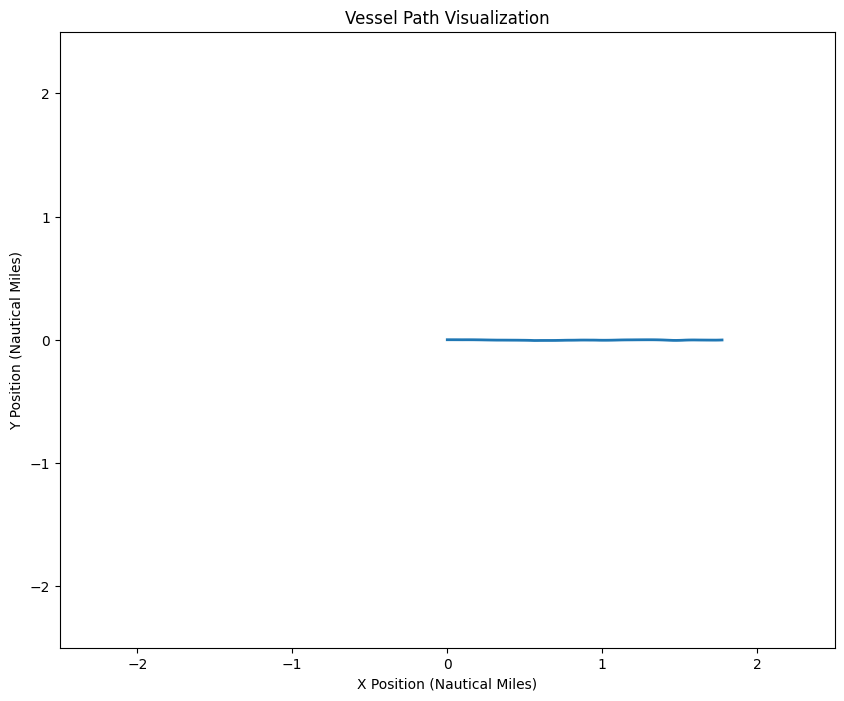

In [12]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Input and output folders
input_folder = "time_sets_st_shortened"
output_folder = "visualizations_time_sets_shortened"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all CSV files in the input folder
all_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Select a random 10% of the files
sample_files = random.sample(all_files, max(1, len(all_files) // 10))
print(f"Selected {len(sample_files)} files out of {len(all_files)} for visualization.")

def visualize_vessel_path(file_path, output_path):
    try:
        # Load the data
        data = pd.read_csv(file_path)

        # Validate required columns
        required_columns = {'Timestamp', 'SOG', 'COG'}
        if not required_columns.issubset(data.columns):
            print(f"Skipping {file_path}: Missing required columns.")
            return

        # Convert 'Timestamp' to datetime
        data['Timestamp'] = pd.to_datetime(data['Timestamp'])
        
        # Calculate time differences (in hours) between consecutive points
        data['time_diff'] = data['Timestamp'].diff().dt.total_seconds() / 3600  # Convert to hours
        
        # For the first row, set time_diff to 0 (no movement at the start)
        data.loc[0, 'time_diff'] = 0  # Fix applied here

        # Calculate the change in position (in nautical miles)
        data['x'] = data['SOG'] * data['time_diff'] * np.cos(np.deg2rad(data['COG']))
        data['y'] = data['SOG'] * data['time_diff'] * np.sin(np.deg2rad(data['COG']))

        # Calculate the cumulative sum of positions
        data['x_cum'] = data['x'].cumsum()
        data['y_cum'] = data['y'].cumsum()

        # Plot the path
        plt.figure(figsize=(10, 8))
        # Plot only the path without dots (no markers)
        plt.plot(data['x_cum'], data['y_cum'], linewidth=2, label='Vessel Path')
        plt.title("Vessel Path Visualization")
        plt.xlabel("X Position (Nautical Miles)")
        plt.ylabel("Y Position (Nautical Miles)")

        # Remove the grid
        # plt.grid(True)  # Commented out to remove the grid

        # Set axis limits to the standardized size
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)

        # Save the plot with a higher resolution (dpi=300)
        plt.savefig(output_path, dpi=300)  # High resolution image (300 dpi)
        plt.close()
        print(f"Saved visualization to {output_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Process each selected file
for file_name in sample_files:
    input_path = os.path.join(input_folder, file_name)
    output_path = os.path.join(output_folder, file_name.replace('.csv', '.png'))
    visualize_vessel_path(input_path, output_path)

print("Visualization process completed.")

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
import random

# Folder containing the .csv files
folder_path = "./time_sets_standardized"

# Map tile size in nautical miles
tile_width_nm = 2.5
tile_height_nm = 2.5

# Conversion from nautical miles to degrees (approximate, depends on latitude)
nm_to_deg = 1 / 60

# Initialize a dictionary to count navigational statuses
nav_status_counts = {}

# Function to calculate bounding box
def calculate_bounding_box(center_lat, center_lon, width_nm, height_nm):
    lat_delta = height_nm * nm_to_deg
    lon_delta = width_nm * nm_to_deg / np.cos(np.radians(center_lat))
    return (center_lat - lat_delta, center_lat + lat_delta,
            center_lon - lon_delta, center_lon + lon_delta)

# Function to plot vessel movements on a map tile
def plot_map(data, file_name, bbox):
    plt.figure(figsize=(8, 8))
    plt.plot(data['Longitude'], data['Latitude'], marker='o', markersize=4, label='Vessel Movement')
    plt.xlim([bbox[2], bbox[3]])  # Set longitude bounds
    plt.ylim([bbox[0], bbox[1]])  # Set latitude bounds
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Vessel Movement: {file_name}")
    plt.legend()
    plt.grid()
    plt.savefig(f"map_tiles/{file_name}.png")
    plt.close()

# Create output folder for map tiles
os.makedirs("map_tiles", exist_ok=True)

# Get the list of CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]

# Select a random 10% of the files (rounding up if necessary)
random_files = random.sample(csv_files, max(1, int(len(csv_files) * 0.1)))

# Process the selected files
for file in random_files:
    file_path = os.path.join(folder_path, file)
    
    # Load CSV file
    data = pd.read_csv(file_path)
    
    # Ensure 'Navigational status' has a single unique value
    unique_status = data['Navigational status'].unique()
    if len(unique_status) == 1:
        status = unique_status[0]
        nav_status_counts[status] = nav_status_counts.get(status, 0) + 1
        
        # Calculate the bounding box for the map tile
        center_lat = data['Latitude'].mean()
        center_lon = data['Longitude'].mean()
        bbox = calculate_bounding_box(center_lat, center_lon, tile_width_nm, tile_height_nm)
        
        # Plot the map tile
        plot_map(data, file.replace(".csv", ""), bbox)

# Display the counts of navigational statuses
print("Counts of Navigational Statuses:")
for status, count in nav_status_counts.items():
    print(f"Status {status}: {count} files")


Counts of Navigational Statuses:
Status Under way using engine: 572 files
Status Engaged in fishing: 393 files
Status Reserved for future amendment [HSC]: 20 files
Status Restricted maneuverability: 34 files
Status Under way sailing: 5 files
Status Moored: 5 files


In [8]:
import os
import pandas as pd

# Folder containing the CSV files
folder_path = "./filtered_area"

# Initialize a set to store unique navigational statuses
unique_statuses = set()

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
                    
        # Read the CSV file, handling the '# Timestamp' column
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
                                                    
        # Add unique Navigational Status values to the set
        if "Navigational status" in df.columns:
               unique_statuses.update(df["Navigational status"].dropna().unique())

# Display one example of each unique Navigational Status
print("Unique Navigational Status entries found in the data:")
for status in unique_statuses:
       print(f"- {status}")


Unique Navigational Status entries found in the data:
- Restricted maneuverability
- Under way using engine
- Engaged in fishing
- Under way sailing
- Moored


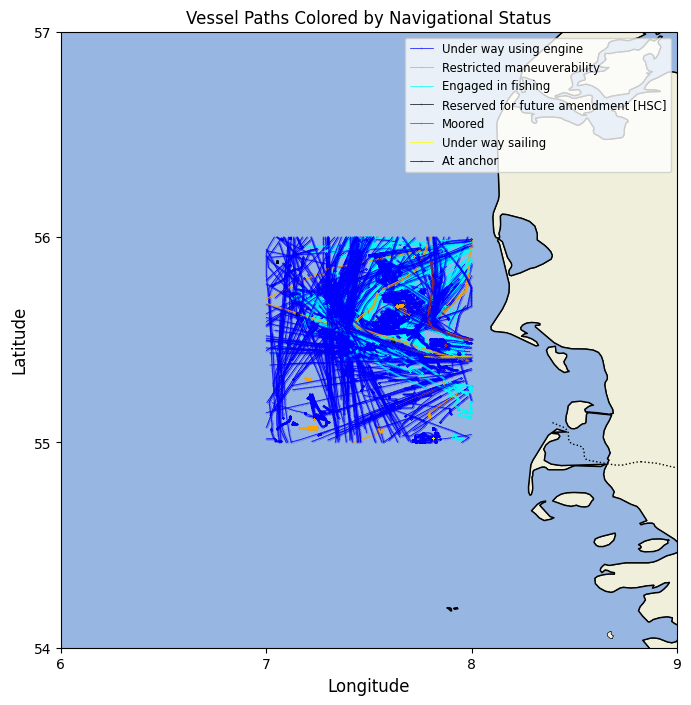

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Folder containing the CSV files
folder_path = "../5_Data_Pipeline/time_sets_standardized"

# Initialize lists to store latitude, longitude, and navigational status data
all_latitudes = []
all_longitudes = []
all_statuses = []

# Loop through all CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file, handling the '# Timestamp' column
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        
        # Extract Latitude, Longitude, and Navigational Status columns
        if "Latitude" in df.columns and "Longitude" in df.columns and "Navigational status" in df.columns:
            all_latitudes.extend(df["Latitude"].dropna())
            all_longitudes.extend(df["Longitude"].dropna())
            all_statuses.extend(df["Navigational status"].dropna())

# Ensure we have data to plot
if not all_latitudes or not all_longitudes or not all_statuses:
    print("No valid latitude/longitude/status data found in the CSV files.")
    exit()

# Determine map bounds with 60 nautical miles extension (1 nautical mile = 1/60 degree)
nautical_mile_in_degrees = 1 / 60
extend_by = 60 * nautical_mile_in_degrees
min_lat, max_lat = min(all_latitudes) - extend_by, max(all_latitudes) + extend_by
min_lon, max_lon = min(all_longitudes) - extend_by, max(all_longitudes) + extend_by

# Determine map bounds
# min_lat, max_lat = min(all_latitudes), max(all_latitudes)
# min_lon, max_lon = min(all_longitudes), max(all_longitudes)

# Create a map with Cartopy
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Add latitude and longitude labels
ax.set_xticks(range(int(min_lon), int(max_lon) + 1, max(1, int((max_lon - min_lon) / 5))), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(min_lat), int(max_lat) + 1, max(1, int((max_lat - min_lat) / 5))), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=10)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

# Define colors for different Navigational Statuses

status_colors = {
    "Under way using engine": "blue",
    "Moored": "brown",
    "Restricted maneuverability": "orange",
    "Engaged in fishing": "cyan",
    "Under way sailing": "yellow"
}

# Plot vessel paths colored by Navigational Status
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path, skipinitialspace=True)
        df.rename(columns=lambda x: x.strip(), inplace=True)
        
        # Plot the vessel path
        if "Latitude" in df.columns and "Longitude" in df.columns and "Navigational status" in df.columns:
            for status, group in df.groupby("Navigational status"):
                latitudes = group["Latitude"].dropna()
                longitudes = group["Longitude"].dropna()
                color = status_colors.get(status, "black")  # Default to black if status is unknown
                ax.plot(longitudes, latitudes, marker='o', linestyle='-', linewidth=0.5, markersize=0.1, color=color, transform=ccrs.PlateCarree(), label=status)

# Add legend and title
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small')
plt.title("Vessel Paths Colored by Navigational Status")

# Show the map
plt.show()
